In [104]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv, matrix_power, eigh
from scipy.optimize import curve_fit
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['font.size']=20
from scipy.linalg import expm, sqrtm
from scipy.stats import linregress
from math import acos, factorial
from scipy.special import eval_genlaguerre, gamma, hyp1f1

In [105]:
#Definition of the Key Parameters
dim=10 #Dimension  of the Hilbert a.k.a Random matrices of dimension dim x dim
A=1 #Probability distribution to take the RMT elements will be P~exp(-A x^2)
sigma=np.sqrt(A/2) #Standard deviation of the normal distribution
basis = np.identity(dim)
i=complex(0,1)
β=0.1 #Inverse temperature
tmax=1 #Maximum time we simulate. (Dimensionless) Typicaly the dip is found at t<=1
n_points_t=100 #Number of points in the time array
xlogscale=False #If True the time points will be uniformly distributed in logscale
if xlogscale:
    auxtmin=-1.5 #tmin=10**auxtmin
    auxtmax=np.log10(tmax)
    auxt=np.linspace(auxtmin, auxtmax, n_points_t)
    t_arr=10**(auxt)
else:
    t_arr=np.linspace(0, tmax, n_points_t)
Nav=100 #Number of random matrices to average over
hbar=1 #We use hbar=1

#Comment on dimensions of quantities: 
#Both the time and the inverse temperature are dimensionless. The underlying dimension of
#energy is given by A which gives a dimension to the elements of the Random Matrix

In [106]:
#Basic subroutines:
#Compute the dot product between a bra and a ket. Returns a complex number
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0
#Compute the product between a jet and a bra. Returns an operator over the Hilbert space
@numba.jit(complex128[:,:](complex128[:], complex128[:]), nopython=True, fastmath=True, parallel=False)
def ketbra(ket, bra):
    dim=len(ket)
    res=np.zeros((dim, dim), dtype=complex128)
    for j in range(dim):
        for k in range(dim):
            res[j,k]=ket[j]*np.conjugate(bra[k])
    return res

In [107]:
#Construct a Random Gaussian Orthogonal Matrix GOE (Time Reversal Symmetry is present)
@numba.jit(float64[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GOE(N, sigma):
    auxH = np.random.randn(N,N) #Creates a random array normally distributed. Assumes sigma=1
    H=(auxH+auxH.T) #Summing any matrix and its transpose gives a symmetric matrix
    return H
#Construct a Random Gaussian Hermitian Matrix. GUE (No Time-Reversal Symmetry)
@numba.jit(complex128[:,:](int64, float64), nopython=True, parallel=False, fastmath=True)
def RMT_GUE(N, sigma):
    H=np.zeros((N, N), dtype=complex128) #Define a N x N matrix
    for j in range(N):
        H[j,j]=np.random.normal(0,sigma) #The elements in the diagonal are real.
        for k in range(j+1, N):
            a=np.random.normal(0,sigma)/np.sqrt(2) #Elements out of diagonal
            b=np.random.normal(0,sigma)/np.sqrt(2) #Take care with the sqrt(2) dividing
            #With this sqrt(2) the average modulus of the random numbers is the same as in 
            #the diagonal
            H[j,k]=complex(a,b)
            H[k,j]=complex(a,-b)
    return H

The regularized OTOC is defined for any two operators $V$, $W$ as
$$F_\beta(t):=Z^{-1}(\beta)\mathrm{Tr}\{e^{-\beta H/4}Ve^{-\beta H/4}W(t)e^{-\beta H/4}V e^{-\beta H/4}W(t)\}$$
We will consider the operators
$$V=|m\rangle \langle n|, \qquad W(t)=e^{i(E_n-E_m)t}|n\rangle \langle m|$$
With this each regularized OTOC will be $F_{mn}(t)$ and the total OTOC
$$F(t)=\sum_{m,n}F_{mn}(t)$$
With this selection of $V, W(t)$ we can relate the OTOC with the Spectral Form Factor $g(\beta, t)$:
$$F_\beta(t)= \frac{g(\beta/2, 2t)}{Z(\beta)}=\frac{Z(\beta/2 + 2 i t) Z(\beta/2 - 2 i t)}{Z(\beta)}$$
When taking the average over the GUE (or GOE) there are two versions of the quantities. Say a quantity is given $A(\beta, t)/B(\beta, t)$, then
$$\Big \langle \frac{A(\beta, t)}{B(\beta, t)} \Big \rangle \approx \frac{\langle A(\beta, t) \rangle }{\langle B(\beta, t) \rangle }$$
Typically the one we will be able to compare with analytics is the second one, also known as "annealed" version.

In [108]:
#Regularized OTOC. This subroutine is very slow for that reason we typically don't use it.
@numba.jit(complex128(complex128[:,:], float64, float64[:], complex128[:,:], float64), nopython=True, parallel=False, fastmath=True)
def F(y, Z, E, ket_n, t):
    F=0
    for n in range(dim):
        for m in range(dim):
            auxnm=ketbra(ket_n[:,n], ket_n[:,m])
            V=ketbra(ket_n[:,m], ket_n[:,n])
            W_t=np.exp(i*(E[n]-E[m])*t)*auxnm
            F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
    return F
#Compute the analytically continued partition function given the spectrum E of the system
#The β parameter may be complex valued.
@numba.jit(complex128(complex128, float64[:]))
def Z_c(β, E):
    Z=np.sum(np.exp(-β*E))
    return Z

<ipython-input-108-dd888bd9f778>:10: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
<ipython-input-108-dd888bd9f778>:10: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  F+=(np.trace(y@V@y@W_t@y@V@y@W_t))/Z
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, A), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 2d, C), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


In [109]:
#The commented lines of code compute the non-annealed version of F(β, t) using the 
#full definition. This is a very slow procedure, for this reason we usually compute 
#the annealed version directly from the product Z(β/2 + 2 i t)Z(β/2 - 2 i t) where Z is 
#computed numerically from the energies

#F_arr=np.zeros((n_points_t, Nav), dtype=complex)
F_Z_arr=np.zeros((n_points_t, Nav), dtype=complex)
Z_arr=np.zeros(Nav)
for j in range(Nav):
    H=RMT_GUE(dim, sigma) #Create random Matrix from GUE
    E, ket_n=eigh(H) #Diagonalize it
    if np.any(np.imag(E)>1e-8): 
        print("Problems") #Ensures that we have real eigenvalues
        print(np.max(np.imag(E)))
    Z=np.real(Z_c(β, E)) #Computes the partition function at temperature β
    Z_arr[j]=Z #Stores the partition function in an array to average it
    #Computes the exp(-β H/4) factor needed for the OTOC
    """y=np.zeros((dim, dim), dtype=complex)
    for k in range(dim):
        aux=ketbra(ket_n[:,k], ket_n[:,k])
        y+=np.exp(-β*E[k]/4)*aux"""
    for k in range(n_points_t):
        #F_arr[k,j]=F(y, Z, E, ket_n, t_arr[k])
        Zaux1=Z_c(β/2+2*i*t_arr[k], E) #Computes the analytically continued partition function
        Zaux2=Z_c(β/2-2*i*t_arr[k], E)
        F_Z_arr[k,j]=Zaux1*Zaux2
avZ=np.average(Z_arr) #Average Partition function
#F_t=np.average(F_arr, axis=1)
F_Z=np.average(F_Z_arr, axis=1)/avZ #Annealed OTOC 
#sigmaF_t=np.std(np.real(F_arr), axis=1) #Standard deviation of F

In [110]:
#Subroutine to compute the Generalized Laguerre Polynomials (does the same as eval_genlaguerre)
def GenLag(n, alpha, x):
    L=0
    for j in range(n+1):
        L+=gamma(n+alpha+1)*(-x)**j/(gamma(n-j+1)*gamma(alpha+j+1)*factorial(j))
    return L

Analytical solution for SFF and partition function of the GUE:
$$\langle Z(\sigma) \rangle_{GUE}= e^{\sigma^2/4} L^1_{N-1}\left( -\frac{\sigma^2}{2}\right)$$
where $\sigma=\beta + i t$ and $L^\alpha_n(x)$ is the generalized Laguerre Polynomial, defined as
$$L^\alpha_n(x) = \sum_{j=0}^n \left(\begin{array}{c}n + \alpha \\ n - j\end{array}\right) \frac{(-x)^j}{j!}$$
With this the SFF can be written as three terms
$$g(\beta, t) = \langle Z(2 \beta) \rangle + |\langle Z(\beta + i t) \rangle |^2 + g_c(\beta, t)$$
where $g_c(\beta, t)$ is the connected part of the SFF
$$g_c(\beta, t) = - e^{(\sigma^2 + {\sigma^*}^2)/4}\sum_{m,n}^{N-1} c_{mn} \left( \frac{|\sigma|^2}{2} \right)^{|n-m|} |L^{|n-m|}_{min(n,m)}(-\sigma^2/2)|^2$$
where $c_{mn}=min(n,m)!/max(n,m)!$.

In [111]:
#Compute the averaged (analytically continued) Partition Function for the GUE.
def avZGUE(sigma, dim):
    return np.exp(sigma**2/4)*eval_genlaguerre(dim-1, 1, -sigma**2/2)
    #return np.exp(sigma**2/4)*GenLag(dim-1, 1, -sigma**2/2)
#Compute the connected part of the SFF averaged for the GUE
def gcGUE(sigma0, dim):
    gc=0
    for n in range(dim):
        for m in range(dim):
            cmn=factorial(np.min([n,m]))/factorial(np.max([n, m]))
            dnm=np.abs(n-m)
            minnm=np.min([n,m])
            poly=eval_genlaguerre(minnm, dnm, -sigma0**2/2)
            gc+=cmn*(np.conjugate(sigma0)*sigma0/2)**dnm*np.conjugate(poly)*poly
    return -np.exp((sigma0**2+(np.conjugate(sigma0))**2)/4)*gc
#COmpute the total SFF averaged over the GUE
def avgGUE(beta, t, dim):
    term1=avZGUE(2*beta, dim)
    term2=avZGUE(beta+i*t, dim)
    #term2=(np.abs(term2))**2
    term2=np.conjugate(term2)*term2
    term3=gcGUE(beta+i*t, dim)
    return term1+term2+term3
if xlogscale:
    t=np.linspace(10**auxtmin, tmax, 10000)
else:
    t=np.linspace(0, tmax, 10000)
analyticF=avgGUE(β/2, 2*t, dim)/avZGUE(β, dim)

In [112]:
#Analyze the contributions and approximations to the SFF
plotSFF=False
if plotSFF:
    total=avgGUE(β, t, dim)
    term1=avZGUE(2*β, dim)*np.ones(10000)
    term2=avZGUE(β+i*t, dim)
    term2=np.conjugate(term2)*term2
    term3=gcGUE(β+i*t, dim)
    aux=(np.abs(eval_genlaguerre(dim-1, 1, -(β+i*t)**2/2)))**2
    #aux2=(np.abs(L12(-(β+i*t)**2/2)))**2
    plt.figure()
    plt.plot(t, total, label='Total SFF', color='black', lw=4)
    #plt.plot(t, term1, label='Term 1', color='orange')
    plt.plot(t, term2, label=r'$|\langle Z(\beta + i t) \rangle |^2$', ls='-.', color='red')
    plt.plot(t, (1 - dim*0.5*t**2+(t**2/2)**2*(5*dim**2-1)/12)*dim**2, label='$o(t^4)$ approx.', ls='--')
    #plt.plot(t, dim**2*(1 - ((dim-1)**2/4)*(t**2/2)**2 - (dim -1)*(t**2/2))*np.exp(-t**2/2))
    plt.plot(t, np.exp(-dim*t**2/2)*dim**2, label=r"$e^{- N t^2/2}$", ls='--')
    #plt.plot(t, np.exp(-(dim+3)*(t-0.5)), label=r"$e^{- N (t-t^*)}$", ls=':', lw=3)
    #plt.plot(t, (dim**2 - 0.5*np.exp(dim*(t))))
    #plt.plot(t, term3, label='Term 3', color='blue')
    #plt.xscale('log')
    #plt.grid()
    #plt.xlim(t[0], 1)
    plt.yscale('log')
    plt.ylim(1e-1, dim**2)
    plt.xlabel("$t$")
    plt.ylabel(r"$g(\beta=0, t)$")
    plt.legend(labelspacing=0)
    plt.show()

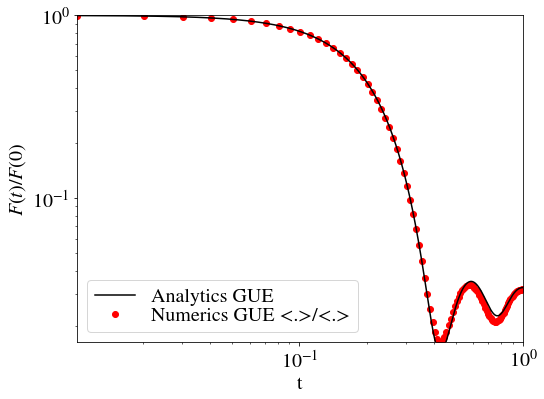

In [113]:
fhat=np.real(F_Z/F_Z[0]) #Define Fhat=F(t)/F(0)
plt.figure(figsize=[8, 6])
minf=np.min(fhat)
plt.scatter(t_arr, fhat, label='Numerics GUE <.>/<.>', color='red')
plt.plot(t, np.real(analyticF/analyticF[0]), color='black', label='Analytics GUE')
#plt.scatter(t_arr, np.real(F_t/F_t[0]), label='Numerics GUE <./.>')
plt.xlabel("t")
plt.ylabel("$F(t)/F(0)$")
plt.xscale('log')
plt.yscale('log')
plt.xlim(t_arr[1],1)
plt.ylim(np.min(fhat), 1)
plt.legend(labelspacing=0)
plt.show()

In [114]:
def expF(t, a, b):
    return a*np.exp(-b*t)
def LogMean(x, y):
    return np.exp((np.log(x)+np.log(y))/2)
def linFit(x, res):
    return res.slope*x+res.intercept
def evenlySpacedFPoints(Fmax, Fmin, npoints):
    arrexp=np.linspace(0, np.log10(Fmax/Fmin), npoints)
    arr=Fmin*10**arrexp
    return arr

### Obtaining the Lyapunov exponent from the OTOC

According to Maldacena $F(t)$ obeys the scaling for $t_d \ll t \ll t_E$
$$F_0 - F(t) \propto \frac{e^{\lambda t}}{N}$$
where $\lambda$ is the Lyapunov exponent and the timescales are determined by
$$t_d\sim\frac{1}{\lambda}, \qquad t_E \sim \frac{\log N}{\lambda}$$
Instead of choosing these timescales we will choose windows of F in which we fit our data to a function $a e^{-\lambda t}$. Instead of fitting to a exponential we will take $-\ln (\tilde{F})$ and fit that to a linear function.

In [115]:
#Parameters of the fit
coef_range_fitted=0.5 #Less than one. Gives the part of the range between the central point 
#of the fit and the minimum value of Fhat
n_regions_fitted=10 #Number of regions in which we will fit

In [116]:
#First we will find the first dip (need not be the deepest one) and take only those values

#Gives the relative minima of fhat
arr_minima=np.r_[True, fhat[1:] < fhat[:-1]] & np.r_[fhat[:-1] < fhat[1:], True]
t_dip=np.min(t_arr[arr_minima]) #we take the smallest of those relative minima
fhat_aux=fhat[t_arr<t_dip] #Take only the values of fhat before the dip
t_arr_aux=t_arr[t_arr<t_dip]
pInflect=np.argmin(np.diff(fhat_aux)) #gives the inflection point of fhat
FInflect=fhat[pInflect]
pInflectlog=np.argmin(np.diff(np.log(fhat_aux))) #gives the inflection point of log(fhat)
FInflectLog=fhat[pInflectlog]
#We will fit the Lyapunov in n_regions_fitted points between the FInflectLog and FInflect
centerFitArr=evenlySpacedFPoints(FInflect, FInflectLog, n_regions_fitted)
auxlambda=[]
auxerr=[]
auxn=[]
#For every fitted point we compute the variance of the fit to a linear f(t)=a t + b (after 
#taking the log) and the variance of the fit to a quadratic function h(t)=a' t^2 + b. 
#We take the value of the Lyapunov (linear fit) if Var_linear<Var_quadratic or if
#Var_linear<cutoffVar.
cutoffVar=1e-3
for j in range(len(centerFitArr)):
    minF_fit=centerFitArr[j]-coef_range_fitted*(centerFitArr[j]-fhat_aux[-1])
    maxF_fit=centerFitArr[j]+coef_range_fitted*(centerFitArr[j]-fhat_aux[-1])
    F_fit=fhat_aux[fhat_aux>minF_fit]
    t_fit=t_arr_aux[fhat_aux>minF_fit]
    t_fit=t_fit[F_fit<maxF_fit]
    F_fit=F_fit[F_fit<maxF_fit]
    logF=-np.log(F_fit)
    res=linregress(t_fit, logF)
    res2=linregress(t_fit**2, logF)
    Var=np.sum((linFit(t_fit, res)-logF)**2)
    Var2=np.sum((linFit(t_fit**2, res2)-logF)**2)
    if Var<Var2 or Var<cutoffVar:
        auxlambda.append(res.slope)
        auxerr.append(res.stderr)
        auxn.append(res.intercept)
lyap=np.average(auxlambda)
linearcoef=np.average(auxn)
auxerr=np.asarray(auxerr)
std_lyap=np.sqrt((np.std(auxlambda))**2+np.sum(auxerr**2))

27.671664136275993


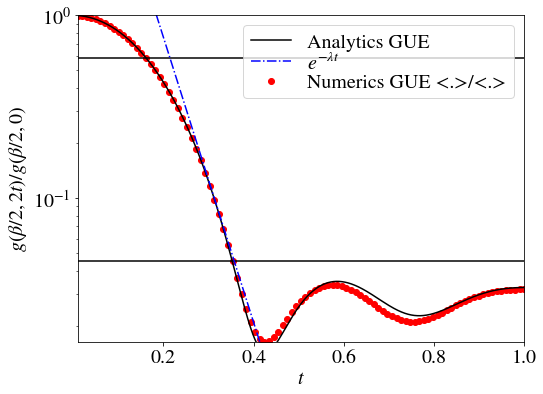

In [119]:
print(np.exp(-linearcoef))
plt.figure(figsize=[8, 6])
plt.scatter(t_arr, fhat, label='Numerics GUE <.>/<.>', color='red')
plt.plot(t, np.real(analyticF/analyticF[0]), color='black', label='Analytics GUE')
plt.plot(t, np.exp(-(lyap*t+linearcoef)), color='blue', ls='-.', label=r'$e^{-\lambda t}$')
plt.hlines(FInflectLog,0, 2)
plt.hlines(FInflect, 0, 2)
plt.xlabel("$t$")
plt.ylabel(r"$g(\beta/2, 2t)/g(\beta/2, 0)$")
#plt.xscale('log')
plt.yscale('log')
plt.xlim(t_arr[1], 1)
plt.ylim(np.min(fhat), 1)
plt.legend(labelspacing=0)
plt.show()